# ESDC Application

In [299]:
import sys

sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.classification import load_esdc

# Feature Extraction/Transformations
from src.features.classification import add_drought_mask, extract_df, subset_time, extract_region
from src.features.stats import calculate_classification_stats
from sklearn.model_selection import train_test_split
from esdc.shape import rasterize
import geopandas as gpd

# SVM Model and Derivative functions
from src.models.classification import svm_naive, predict_batches
from src.models.derivatives import SVMDerivative

# Visualization
from esdc.visualize import plot_xarray_on_map, plot_map
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use('ggplot')

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment

In [300]:
DROUGHT_PATH = "/media/disk/databases/DROUGHT/eastern_europe/"

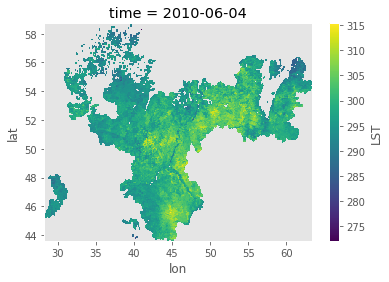

In [301]:
# Load Data
ee_drought = xr.open_dataset(DROUGHT_PATH + "AD_europe_5D.nc").isel(time=2).LST
ee_drought.plot()

## Data

### Eastern-European Dataset

In [302]:
datacube = load_esdc()
datacube

,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray


#### Time Component

In [303]:
datacube = subset_time(datacube, ('July-2010', 'July-2010'))

#### Region

In [304]:
datacube = extract_region(datacube, 'eastern_europe')

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


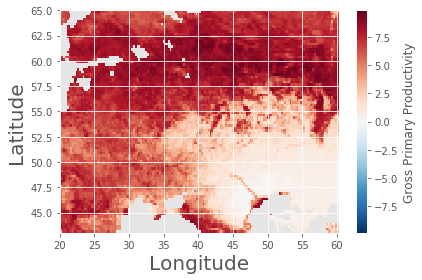

In [305]:
fig, ax = plot_map(
    datacube.gross_primary_productivity.sel(time=slice("July-2010", "July-2010")).mean(dim='time'),
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

### Drought Occurence

In [306]:
def add_drought_mask(xr_data: xr.Dataset, ):

    # open drought data
    drought_xr = xr.open_dataset(DROUGHT_PATH + "AD_europe_5D.nc").isel(time=2).LST

    # Hack (turn into dataframe, easier to manipulate)
    drought_df = drought_xr.to_dataframe().dropna().drop(columns={'time'}).drop_duplicates().reset_index()
    drought_df['LST'] = 1.0
    
    # convert to geopandas df
    drought_df = gpd.GeoDataFrame(
        drought_df, 
        geometry=gpd.points_from_xy(
            drought_df.lon,
            drought_df.lat
        )
    )
    xr_data.coords['drought'] = rasterize(drought_df['geometry'], xr_data)
    
    return xr_data

In [307]:
# datacube_sub.coords['drought'] = rasterize(new_gdf['geometry'], datacube_sub)
datacube = add_drought_mask(datacube)
datacube

<xarray.Dataset>
Dimensions:                     (lat: 88, lon: 161, time: 3)
Coordinates:
  * lon                         (lon) float32 20.125 20.375 ... 59.875 60.125
  * time                        (time) datetime64[ns] 2010-07-08 ... 2010-07-24
  * lat                         (lat) float32 64.875 64.625 ... 43.375 43.125
    drought                     (lat, lon) float64 nan nan nan ... nan nan nan
Data variables:
    gross_primary_productivity  (time, lat, lon) float32 5.457552 ... 4.0935225
    root_moisture               (time, lat, lon) float32 0.18026675 ... 0.050039615
Attributes:
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x720x1440
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    creator_email:             info@earthsystemdatalab.net
    creator_name:              Brockmann Consult GmbH 
    creator_url:               www.earthsystemdatalab.net
    date_created:              17.12.2018
    date_issued:               19.12.2018
    date_modified:             17.12.2018
    geospatial_lat_max:        89.75
    geospatial_lat_min:        -89.75
    geospatial_lon_max:        179.75
    geospatial_lon_min:        -179.75
    geospatial_resolution:     1/4deg
    history:                   - processing with esdl cube v0.1  (https://git...
    id:                        v2.0.0
    institution:               Brockmann Consult GmbH 
    keywords:                  Earth Science, Geophysical Variables
    license:                   Please refer to individual variables
    naming_authority:          Earth System Data Lab team
    processing_level:          Level 4
    project:                   ESA Earth System Data Lab 
    publisher_email:           info@earthsystemdatalab.net
    publisher_name:            Brockmann Consult GmbH & Max Planck Institute ...
    publisher_url:             www.brockmann-consult.de
    standard_name_vocabulary:  CF-1.7
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P37Y
    time_coverage_end:         30.12.2016
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1980
    title:                     Earth System Data Cube

#### Visualize

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


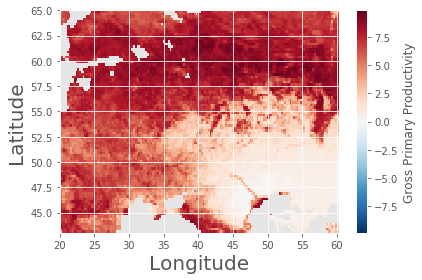

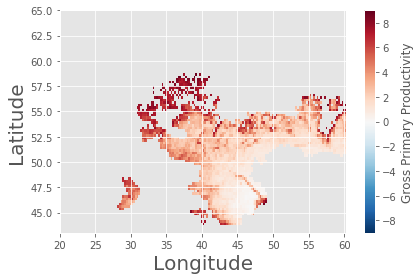

In [308]:
fig, ax = plot_map(
    datacube.gross_primary_productivity.mean(dim='time'),
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    datacube.gross_primary_productivity.mean(dim='time').where(datacube.drought > 0),
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
    if summer:
        cube_russia = dict(list(cube_russia.groupby("time.season")))["JJA"]

### Input Data

In [309]:
df_cube = datacube.to_dataframe()
df_cube['drought'] = df_cube['drought'].fillna(0.0)
df_cube = df_cube.dropna()

In [310]:
df_cube.head()

gross_primary_productivity  root_moisture  drought
lat    lon    time                                                          
64.875 20.125 2010-07-08                    5.457552       0.180267      0.0
              2010-07-16                    5.487429       0.169779      0.0
              2010-07-24                    5.097528       0.168589      0.0
       20.375 2010-07-08                    6.119224       0.177778      0.0
              2010-07-16                    6.142915       0.168019      0.0

### Train Test Split

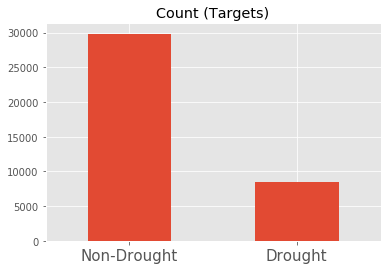

In [311]:
fig, ax = plt.subplots()
df_cube.drought.value_counts().plot(ax=ax, kind='bar', title='Count (Targets)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

#### Strategy 1: Stratify Based on class labels

In [389]:
drought_train, drought_test = train_test_split(
    df_cube[df_cube['drought']==1.0], 
    train_size=500, 
#     test_size=5_000, 
    random_state=123, 
#     stratify=df_cube[['drought']]
)

ndrought_train, ndrought_test = train_test_split(
    df_cube[df_cube['drought']==0.0], 
    train_size=1_500, 
#     test_size=5_000, 
    random_state=123, 
#     stratify=df_cube[['drought']]
)

train = pd.concat([drought_train, ndrought_train], axis=0)
test = pd.concat([drought_test, ndrought_test], axis=0)

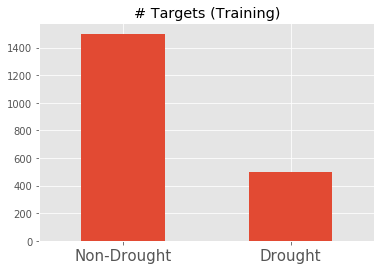

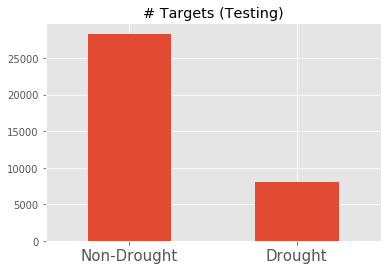

In [390]:
fig, ax = plt.subplots()
train.drought.value_counts().plot(ax=ax, kind='bar', title='# Targets (Training)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

fig, ax = plt.subplots()
test.drought.value_counts().plot(ax=ax, kind='bar', title='# Targets (Testing)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

In [391]:
meta_vars = ['lat', 'lon', 'time']
input_vars = ['gross_primary_productivity', 'root_moisture']
output_vars = ['drought']

## Algorithm

### Support Vector Machine

In [392]:
svm_naive?

Signature: svm_naive(X_train, y_train, n_grid: int = 20, class_weight=None, **kwargs) -> sklearn.base.BaseEstimator
Docstring:
Naive implementation of the Support Vector Machine
classifcation function in the scikit-learn package. It
returns all of the necessary things needed to analyze the
results and possibly reuse the trained SVC model.

Parameters
----------
X_train : array, (N x D)
      an array of training points

y_train : array, (N x 1)
      an array of labels for the training points

n_grid : int, default=100
      the number of grid points to use for the parameter grid

kwargs : dict
      a dictionary of keyword arguments to use for the gridsearch. 
      Please see the sklearn.svm.SVC function for more details
      on the available arguments

Returns
-------

model : class,
      a class of the SVMModel.

Information
-----------
Author: J. Emmanuel Johnson
Email : jej2744@rit.edu
      : emanjohnson91@gmail.com
Date  : 11th April, 2017
File:      ~/projects/2019_sakame/sr

In [393]:
# fit SVM model
svm_model = svm_naive(
    X_train=train[input_vars].values,
    y_train=train[output_vars].values.reshape(-1,1),
    n_grid=40,
    verbose=1,
    n_jobs=-1,
    class_weight={1: 2}
)

svm_model

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4832 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5682 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6632 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 7682 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:  3.7min finished
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d arr

SVC(C=0.01, break_ties=False, cache_size=200, class_weight={1: 2}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=3.597948717948718,
    kernel='rbf', max_iter=-1, probability=False, random_state=123,
    shrinking=True, tol=0.001, verbose=False)

In [394]:
import joblib

EXP_NAME = "test"
MODEL_PATH = "/home/emmanuel/projects/2019_sakame/models/interim/"
model_name = "svm"
joblib.dump(svm_model, f"{MODEL_PATH}{EXP_NAME}_{model_name}.jb")

['/home/emmanuel/projects/2019_sakame/models/interim/test_svm.jb']

In [395]:
import joblib

EXP_NAME = "test"
MODEL_PATH = "/home/emmanuel/projects/2019_sakame/models/interim/"
model_name = "svm"

svm_model = joblib.load(f"{MODEL_PATH}{EXP_NAME}_{model_name}.jb")

## Predictions: Training Data

In [415]:
# initialize SVM Derivative Model
svm_der_model = SVMDerivative(svm_model)

(
    predictions, 
    derivatives, 
    decision_derivatives, 
    objective_derivatives, 
    mask_derivatives,
    kernel_derivatives
) = predict_batches(
    svm_model, 
    svm_der_model, 
    train[input_vars].values,
    train[output_vars].values,
    batch_size=1_000
)

### Calculate Statistics

Below is a helper function that takes in the labels, predictions and derivatives and returns an `xarray.Dataset` with the results that include the lat, lon and time components. This makes plotting a lot easier.

In [397]:
xr_results = calculate_classification_stats(
    ypred=predictions[:, None], 
    ytest=train[output_vars].values, 
    derivative=derivatives, 
    index=train[output_vars].index,
    obj_derivative=objective_derivatives,
    mask_derivative=mask_derivatives,
    kernel_derivative=kernel_derivatives,
    dec_derivative=decision_derivatives,
)
xr_results

<xarray.Dataset>
Dimensions:             (lat: 88, lon: 161, time: 3)
Coordinates:
  * lat                 (lat) float64 43.12 43.38 43.62 ... 64.38 64.62 64.88
  * lon                 (lon) float64 20.12 20.38 20.62 ... 59.62 59.88 60.12
  * time                (time) datetime64[ns] 2010-07-08 2010-07-16 2010-07-24
Data variables:
    Predictions         (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Labels              (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Sensitivity         (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Obj_Derivative      (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Dec_Derivative      (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Mask_Derivative     (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Kernel_Sensitivity  (lat, lon, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    precision:  0.7208237986270023
    f1:         0.6723585912486659
    accuracy:   0.8465
    recall:     0.63

### Visualization

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


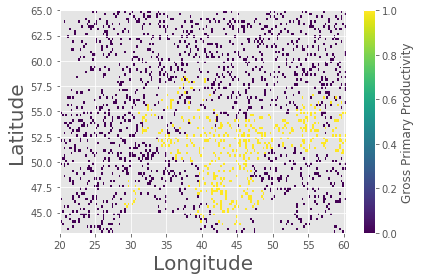

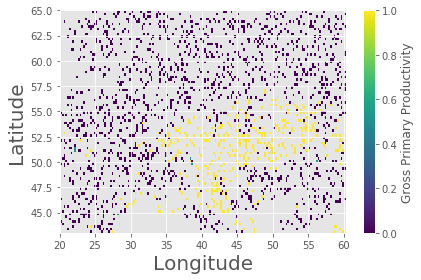

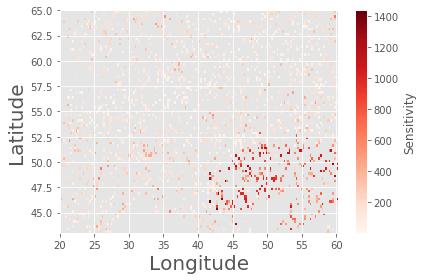

In [398]:
fig, ax = plot_map(
    xr_results.Labels.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Predictions.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Sensitivity.mean(dim='time'),
    cmap="Reds",
    cbar_kwargs = {'label':'Sensitivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()



### Other Derivatives

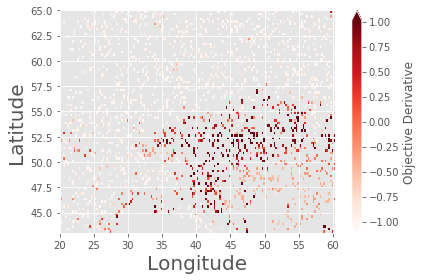

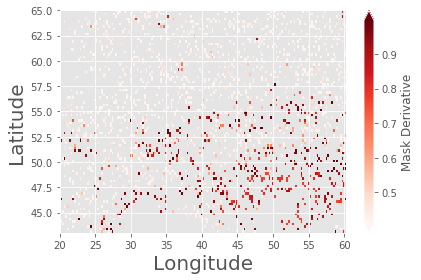

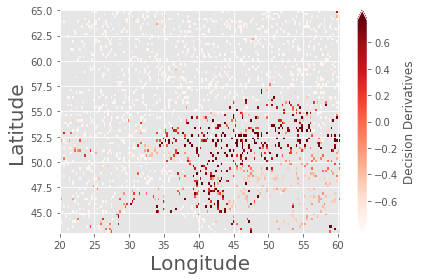

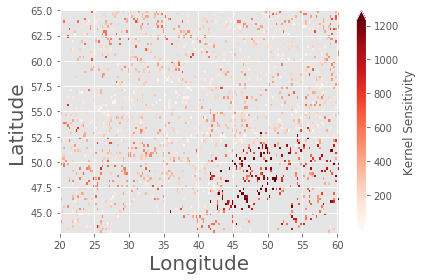

In [399]:
fig, ax = plot_map(
    xr_results.Obj_Derivative.mean(dim='time'),
    cmap="Reds",
    robust=True,
    cbar_kwargs = {'label':'Objective Derivative'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Mask_Derivative.mean(dim='time'),
    cmap="Reds",
    robust=True,
    cbar_kwargs = {'label':'Mask Derivative'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Dec_Derivative.mean(dim='time'),
    cmap="Reds",
    robust=True,
    cbar_kwargs = {'label':'Decision Derivatives'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Kernel_Sensitivity.mean(dim='time'),
    cmap="Reds",
    robust=True,
    cbar_kwargs = {'label':'Kernel Sensitivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

## Predictions: Test Data

In [413]:
from src.visualization.classification import plot_toy_data, plot_predictions, plot_sensitivity


In [424]:
train[output_vars].values.shape,

((2000, 1),)

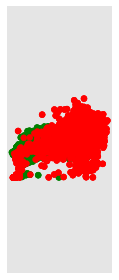

In [440]:
# plot data
fig, ax = plot_toy_data(
    train[input_vars].values,
    train[output_vars].values.squeeze(),
    train[input_vars].values
)

ax.set_aspect(aspect=20.)
plt.tight_layout()
plt.show()

In [496]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import KernelCenterer
from scipy.sparse.linalg import eigs

In [448]:
svm_model.support_vectors_.shape

(1361, 2)

In [488]:
svm_model.gamma

3.597948717948718

In [495]:
new_gamma = svm_model.gamma * 100
new_gamma

359.7948717948718

In [498]:
K = rbf_kernel(train[input_vars].values, gamma=new_gamma)
K_c = KernelCenterer().fit_transform(K)
K_c.shape

(2000, 2000)

In [504]:
K_eigs, K_V = eigs(K, 100)
K_eigs.shape, K_V.shape

((100,), (2000, 100))

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


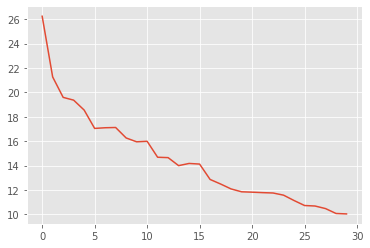

In [505]:
plt.plot(K_eigs[:30])

In [501]:
K_emp = K_V @ np.diag(np.sqrt(K_eigs))

In [508]:
cols = np.vstack((K_emp[0, :], K_emp[30, :])).T
cols.shape

(2000, 2)

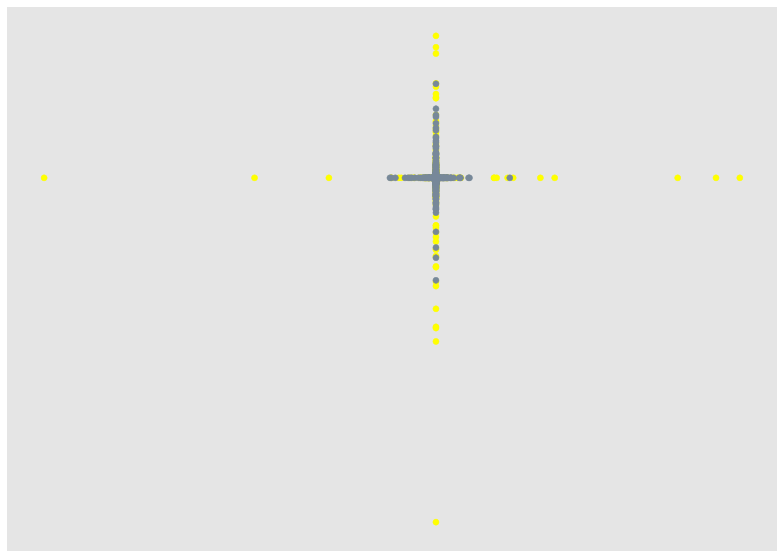

In [509]:
fig, ax = plot_sensitivity(
    xgrid=cols,
    sensitivity=train[output_vars].values.squeeze(),
#     support_vectors=svm_model.support_vectors_
)

# plt.tight_layout()
# ax.set_aspect(aspect=100.)
# ax.legend([]'GPP', 'SM'])
plt.show()

ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 2000, 'y' with size 2000.

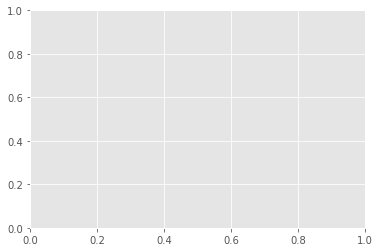

In [467]:
plt.scatter(K_emp[:, 0], K_emp[:, 1], c=["g", "b"])

In [443]:
np.linalg.eig(svm_model.kernel)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

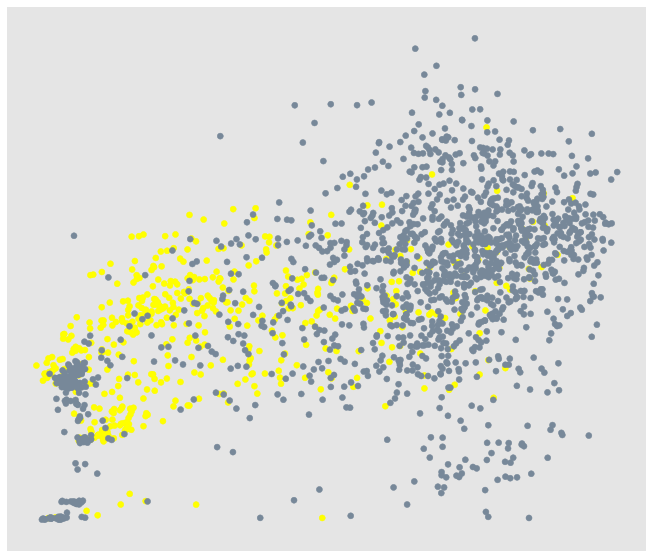

In [510]:
fig, ax = plot_sensitivity(
    xgrid=train[input_vars].values,
    sensitivity=train[output_vars].values.squeeze(),
#     support_vectors=svm_model.support_vectors_
)

# plt.tight_layout()
ax.set_aspect(aspect=20.)
# ax.legend([]'GPP', 'SM'])
plt.show()

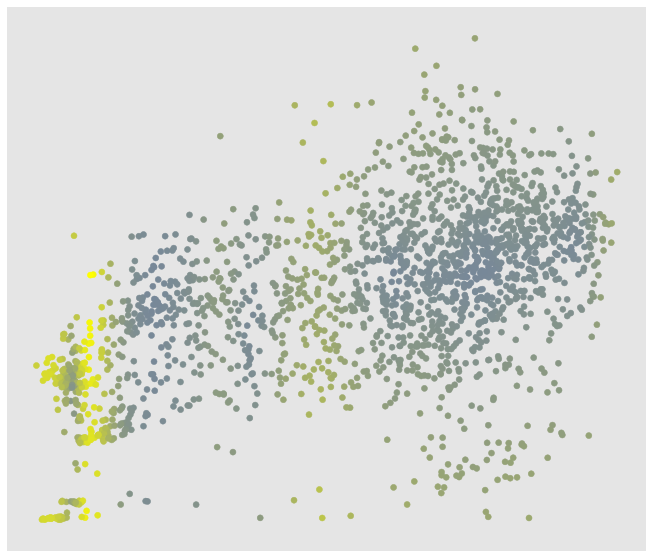

In [512]:
fig, ax = plot_sensitivity(
    xgrid=train[input_vars].values,
    sensitivity=np.abs(derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
plt.show()

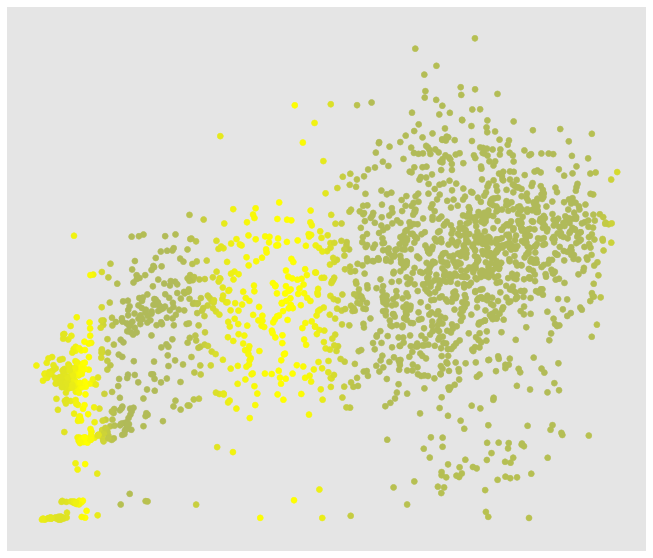

In [513]:
fig, ax = plot_sensitivity(
    xgrid=train[input_vars].values,
    sensitivity=np.abs(mask_derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
plt.show()

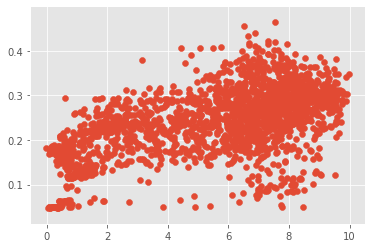

In [411]:
fig, ax = plt.subplots()

ax.scatter(    
    train[input_vars].values[:, 0], 
    train[input_vars].values[:, 1], 
    
)

In [514]:
# initialize SVM Derivative Model
svm_der_model = SVMDerivative(svm_model)

(
    predictions, 
    derivatives, 
    decision_derivatives, 
    objective_derivatives, 
    mask_derivatives,
    kernel_derivatives
) = predict_batches(
    svm_model, 
    svm_der_model, 
    test[input_vars].values,
    test[output_vars].values,
    batch_size=10_000
)

In [515]:
xr_results = calculate_classification_stats(
    ypred=predictions[:, None], 
    ytest=test[output_vars].values, 
    derivative=derivatives, 
    index=test[output_vars].index,
    obj_derivative=objective_derivatives,
    mask_derivative=mask_derivatives,
    kernel_derivative=kernel_derivatives,
    dec_derivative=decision_derivatives,
)
xr_results

<xarray.Dataset>
Dimensions:             (lat: 88, lon: 161, time: 3)
Coordinates:
  * lat                 (lat) float64 43.12 43.38 43.62 ... 64.38 64.62 64.88
  * lon                 (lon) float64 20.12 20.38 20.62 ... 59.62 59.88 60.12
  * time                (time) datetime64[ns] 2010-07-08 2010-07-16 2010-07-24
Data variables:
    Predictions         (lat, lon, time) float64 1.0 0.0 1.0 0.0 ... 1.0 0.0 0.0
    Labels              (lat, lon, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sensitivity         (lat, lon, time) float64 368.9 454.3 ... 563.3 510.7
    Obj_Derivative      (lat, lon, time) float64 0.01849 -0.1872 ... -0.1425
    Dec_Derivative      (lat, lon, time) float64 0.01849 -0.185 ... -0.1415
    Mask_Derivative     (lat, lon, time) float64 0.9997 0.9658 ... 0.9544 0.98
    Kernel_Sensitivity  (lat, lon, time) float64 369.0 470.4 ... 590.2 521.1
Attributes:
    precision:  0.6871329418045916
    f1:         0.6633593196314671
    accuracy:   0.8562902249848726
    recall:     0.6411757379499315

### Results - Classification Report

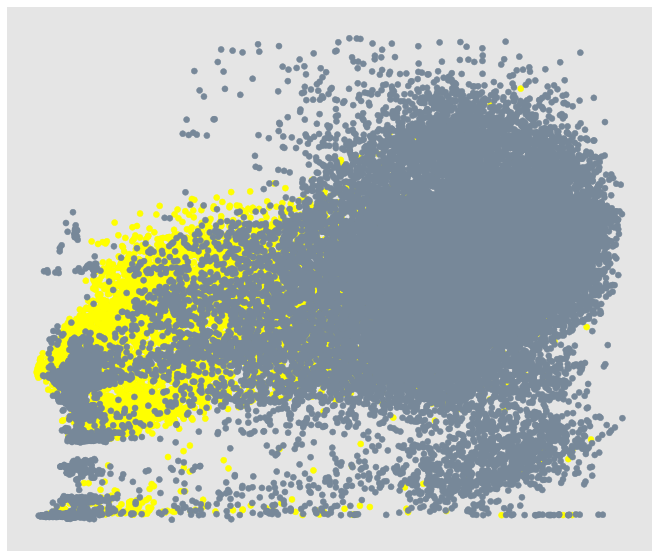

In [516]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=test[output_vars].values.squeeze(),
#     support_vectors=svm_model.support_vectors_
)

# plt.tight_layout()
ax.set_aspect(aspect=20.)
# ax.legend([]'GPP', 'SM'])
plt.show()

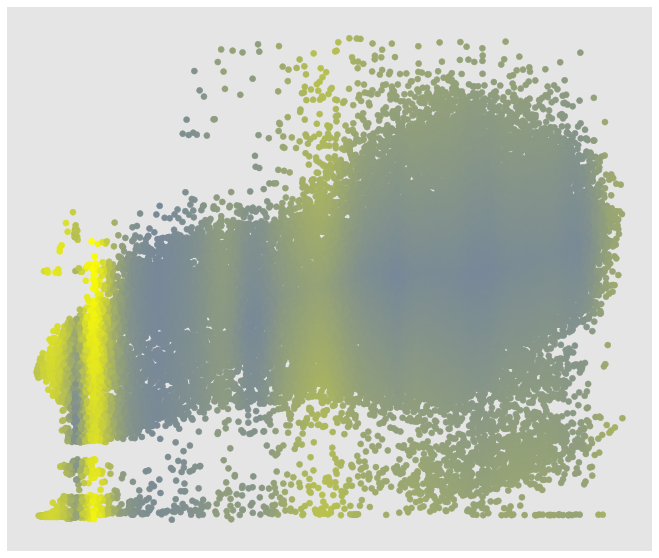

In [517]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=np.abs(derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
plt.show()

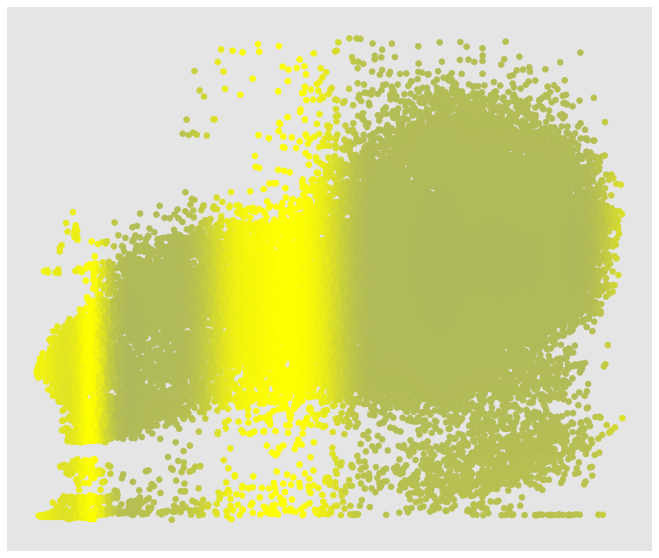

In [521]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=np.abs(mask_derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
# plt.colorbar(ax)
plt.show()

In [522]:
from sklearn.metrics import classification_report


report = classification_report(
    predictions[:, None], 
    test[output_vars].values, 
    target_names=["Non-Drought", "Drought"]
)

print(report)

              precision    recall  f1-score   support

 Non-Drought       0.92      0.90      0.91     28866
     Drought       0.64      0.69      0.66      7492

    accuracy                           0.86     36358
   macro avg       0.78      0.79      0.79     36358
weighted avg       0.86      0.86      0.86     36358



### Visualization

### Viz - Classification Results

##### Classification Colorbar

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


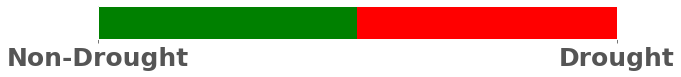

In [403]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap=ListedColormap(["g", "r"])
cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                ticks=[0, 1],  # optional
                                spacing='proportional',
                                orientation='horizontal')
cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=25)
plt.tight_layout()
save_name = "ee_svm_pred_cb.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")
plt.show()

In [404]:
SAVE_PATH = "/home/emmanuel/projects/2019_sakame/reports/figures/esdc/classification/"

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


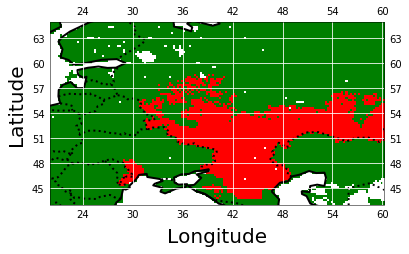

In [405]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = ListedColormap(["g", "r"])
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = matplotlib.colors.ListedColormap(["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap(cmap, 2)
cbar_kwargs = {
    'label':'Labels', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1],
#     "xticklabels": ["Drought", "Not Drought"]
}

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
pts = xr_results.Labels.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
    cmap=cmap
)
# cb = plt.colorbar(pts, orientation="horizontal", fraction=0.065, pad=0.25, ticks=[0, 1])
# cb.set_label(label='Labels', size='large', weight='bold', )
# cb.ax.tick_params(labelsize='large')
# cb.ax.set_yticks([0, 1])
# cb.ax.set_xticklabels(["Not-Drought", "Drought"])

ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')

ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.23, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_labels.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


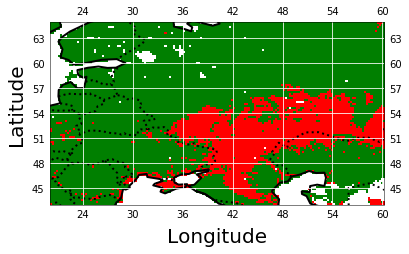

In [406]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

# cmap=plt.cm.get_cmap('RdBu_r', 2)
cmap=ListedColormap(["g", "r"])
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap(cmap, 2)
cbar_kwargs = {
    'label':'Labels', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Predictions.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
    cmap=cmap
)
# cb = plt.colorbar(pts, orientation="horizontal", fraction=0.065, pad=0.25, ticks=[0, 1])
# cb.set_label(label='Labels', size='large', weight='bold', )
# cb.ax.tick_params(labelsize='large')
# cb.ax.set_yticks([0, 1])
# cb.ax.set_xticklabels(["Not-Drought", "Drought"])

ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')

ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.23, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_predictions.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

### Viz - Sensitivity

#### Colorbar

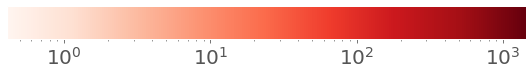

In [407]:
min_sens = np.minimum(
    xr_results.Sensitivity.mean(dim='time').min(),
    xr_results.Kernel_Sensitivity.mean(dim='time').min()
)
min_sens = np.minimum(
    min_sens,
    xr_results.Mask_Derivative.mean(dim='time').min()
)
max_sens = np.minimum(
    xr_results.Sensitivity.mean(dim='time').max(),
    xr_results.Kernel_Sensitivity.mean(dim='time').max()
)
max_sens = np.maximum(
    max_sens,
    xr_results.Mask_Derivative.mean(dim='time').max()
)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.LogNorm(vmin=min_sens, vmax=max_sens)

cb = matplotlib.colorbar.ColorbarBase(
    ax, 
    cmap=cmap,   # Colormap
    norm=norm,
    orientation='horizontal'
)
# cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=20)
# cb.set_label('Sensitivity', fontsize=20, weight='bold')
cb.ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

save_name = "ee_svm_sens_cb.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")

#### Standard Predictions & Sensitivity

#### Viz - Mask Derivative

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


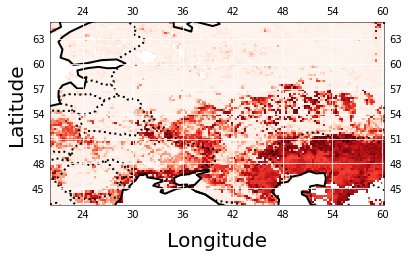

In [408]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Mask_Derivative.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
#     norm=norm,
#     vmin=min_sens, vmax=max_sens,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_mask.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

#### Kernel Derivative

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


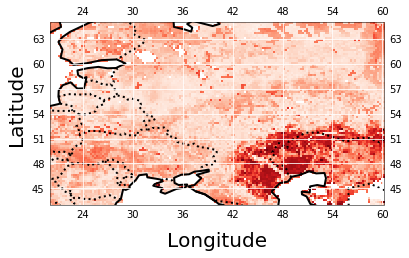

In [409]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Kernel_Sensitivity.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
    vmin=min_sens, vmax=max_sens,
#     norm=norm,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_kernel.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

#### Full Sensitivity

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


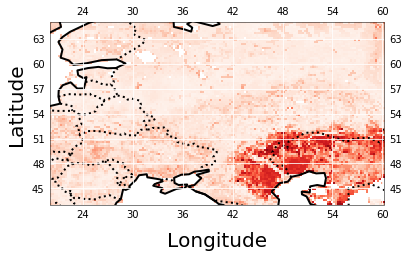

In [410]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}



fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Sensitivity.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
#     norm=norm,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_sens.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)